<a href="https://colab.research.google.com/github/Sabahat-Tufail/EDA/blob/main/EDA_chap_7_cookbook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import files

# Open file picker
uploaded = files.upload()


Saving walmart.csv to walmart.csv


In [98]:
df=pd.read_csv('walmart.csv')

In [89]:
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [90]:
df.dtypes

,0
Store,int64
Date,object
Weekly_Sales,float64
Holiday_Flag,int64
Temperature,float64
Fuel_Price,float64
CPI,float64
Unemployment,float64




# **Transforming object to datetime in Pandas**

When a column contains dates in string form, Pandas stores them as **object** type (basically text).
To work with them as real dates — for sorting, filtering, and extracting year/month/day — you must convert them to **datetime64[ns]** type.



#### **Key Point**

You **must** tell Pandas the correct format of your dates:

* If your dates are **day first** → use format='%d-%m-%Y' or dayfirst=True.
* If your dates are **year first** → use format='%Y-%m-%d'.



#### **Why this matters**

* Correct parsing avoids errors (like your original ValueError).
* Pandas can now:

  * Sort by date correctly.
  * Filter data between date ranges.



In [99]:
df['Date']=pd.to_datetime(df['Date'],format='%d-%m-%Y')

In [100]:
df.dtypes

,0
Store,int64
Date,datetime64[ns]
Weekly_Sales,float64
Holiday_Flag,int64
Temperature,float64
Fuel_Price,float64
CPI,float64
Unemployment,float64


# Set date as index

In [101]:
df.set_index('Date',inplace=True)

In [102]:
print(df.columns)

Index(['Store', 'Weekly_Sales', 'Holiday_Flag', 'Temperature', 'Fuel_Price',
       'CPI', 'Unemployment'],
      dtype='object')


In [103]:
print(df.index.name)

Date


# PLot time series using line plot

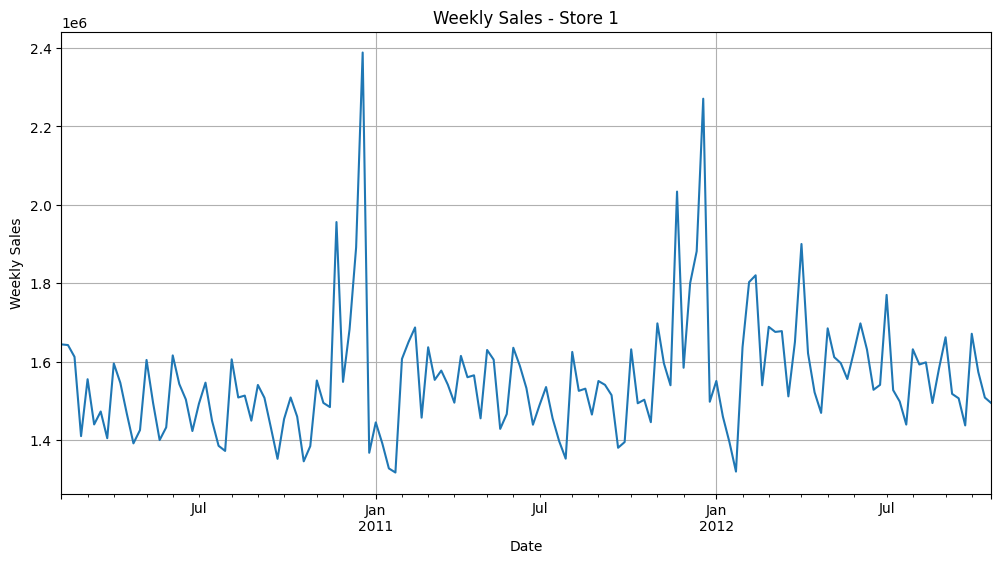

In [ ]:
store_id = 1
df[df['Store'] == store_id]['Weekly_Sales'].plot(figsize=(12,6), title=f'Weekly Sales - Store {store_id}')
plt.ylabel('Weekly Sales')
plt.grid(True)
plt.show()


##Weekly Sales – Store 1

* **X-axis (Date):** Timeline from early 2010 to late 2012.
* **Y-axis (Weekly Sales):** Total weekly sales in millions of currency units for Store 1.



### **Observations:**

1. **Seasonal Peaks:**

   * There are sharp spikes around **late December** each year (holiday season like Christmas/New Year).
   * The highest spike occurs in late 2010, reaching about **2.4 million**.

2. **General Trend:**

   * Sales fluctuate weekly but mostly stay between **1.3M and 1.7M** in non-holiday periods.
   * There is no clear upward or downward long-term trend, but seasonal spikes repeat annually.



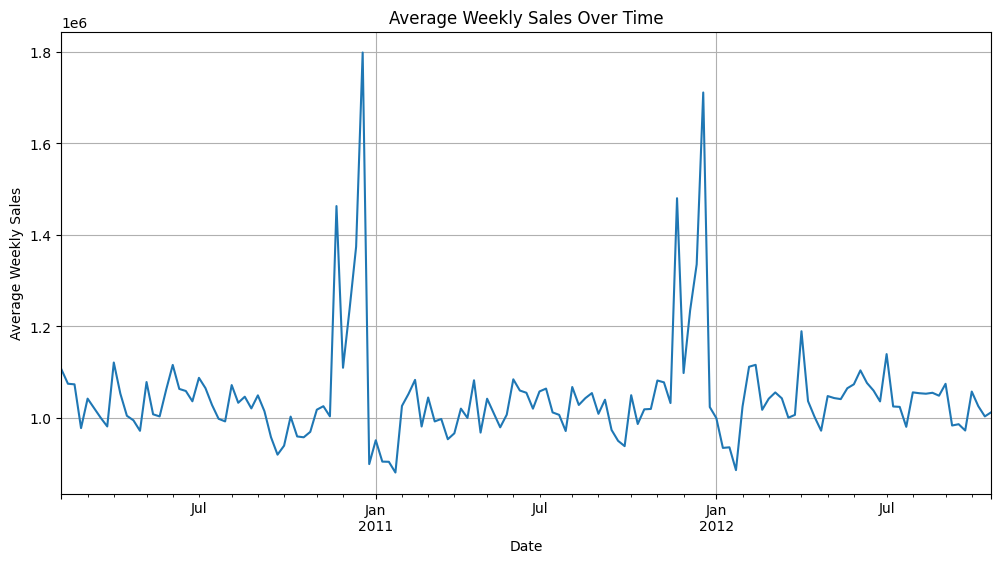

In [ ]:
df.groupby('Date')['Weekly_Sales'].mean().plot(figsize=(12,6), title='Average Weekly Sales Over Time')
plt.ylabel('Average Weekly Sales')
plt.grid(True)
plt.show()


# Seasonal Spikes:

There are two very clear peaks at the end of 2010 and 2011, reaching about 1.8M and 1.7M respectively.

These likely correspond to holiday shopping periods (December).

# Stable Baseline Sales:

For most weeks, average sales hover around 1.0M to 1.1M.

The baseline stays fairly constant over the years, with no long-term upward or downward trend.

# Checking if sales increases at holiday or not
Aggregating sales across all stores by date to get the average.

Separating holiday weeks from normal weeks.

Plotting the overall trend (blue line).

Overlaying holidays (red dots) to visually confirm that spikes match holiday periods.

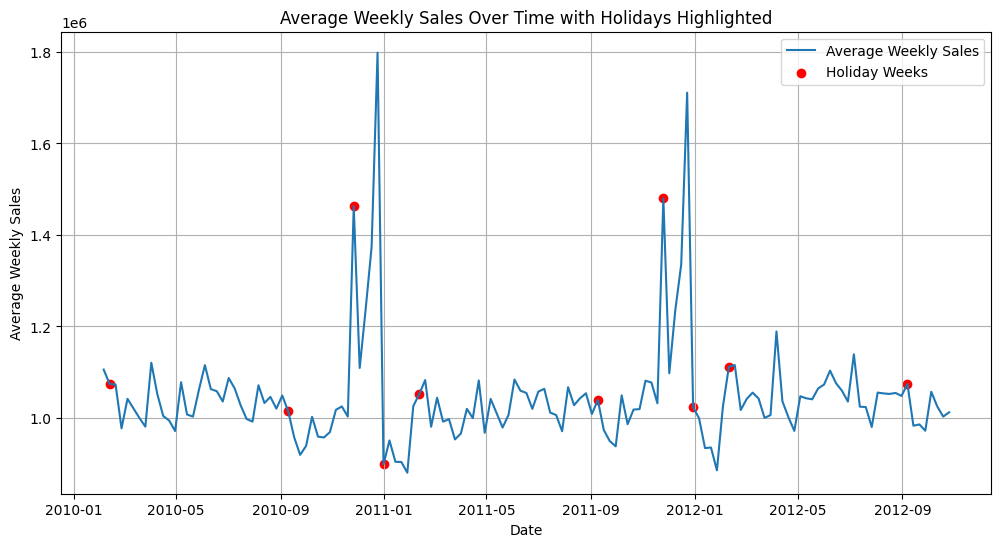

In [ ]:

avg_sales = df.groupby(df.index)['Weekly_Sales'].mean()


holiday_avg_sales = (
    df[df['Holiday_Flag'] == 1]
    .groupby(df[df['Holiday_Flag'] == 1].index)['Weekly_Sales']
    .mean()
)

import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(avg_sales.index, avg_sales.values, label='Average Weekly Sales')
plt.scatter(holiday_avg_sales.index, holiday_avg_sales.values,
            color='red', label='Holiday Weeks')

plt.title('Average Weekly Sales Over Time with Holidays Highlighted')
plt.xlabel('Date')
plt.ylabel('Average Weekly Sales')
plt.legend()
plt.grid(True)
plt.show()


Post-Holiday Dip:

Right after the spikes, there’s a noticeable drop in sales (below 900k), likely due to post-holiday slowdown.

# Plot time series using boxplot

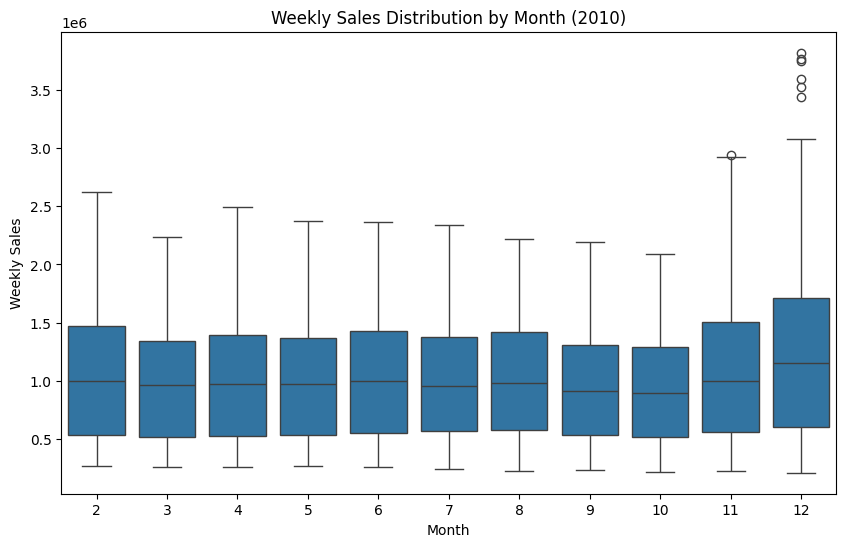

In [ ]:

subset = df[df.index.year == 2010].copy()
subset['Month'] = subset.index.month


plt.figure(figsize=(10,6))
ax = sns.boxplot(data=subset, x='Month', y='Weekly_Sales')

ax.set_title('Weekly Sales Distribution by Month (2010)')
ax.set_xlabel('Month')
ax.set_ylabel('Weekly Sales')

plt.show()


 Each box = Weekly Sales spread for one month

Middle line in the box → median weekly sales for that month.

Top & bottom of the box → the 75th percentile (upper quartile) and 25th percentile (lower quartile).

Whiskers → range of “typical” sales values, excluding extreme outliers.

Dots outside whiskers → outlier weeks (very high or very low compared to the month’s usual sales).



Taller boxes → more variation in weekly sales within that month.

Shorter boxes → more stable weekly sales.

Higher box position → higher sales in that month overall.

Lots of red d

In [ ]:
max_year = df.index.year.max()


print("Max year in dataset:", max_year)


Max year in dataset: 2012


# Performing Time series data Decomposition


##  Why Decompose a Time Series?

A time series is often made up of **three main components**:

1. **Trend** → the long-term direction of the data (upward, downward, or flat)

   * Example: Over several years, Walmart’s average sales may stay flat or grow slightly.

2. **Seasonality** → repeating patterns at fixed intervals

   * Example: Holiday shopping spikes every December, summer dips, etc.

3. **Residual (Noise)** → what’s left after removing trend and seasonality

   * Example: Random fluctuations from promotions, weather, or one-off events.

By **decomposing** the series, you separate these pieces so you can study each one.



##  Additive vs. Multiplicative Models

We can mathematically represent a time series as:

* **Additive**:

  $$
  y(t) = Trend(t) + Seasonality(t) + Residual(t)
  $$

  Use this if seasonal changes are constant in size.

* **Multiplicative**:

  $$
  y(t) = Trend(t) \times Seasonality(t) \times Residual(t)
  $$

  Use this if seasonal changes get bigger when trend is bigger.
  → In your Walmart sales, holiday peaks are **proportionally larger** in high-sales periods, so multiplicative makes sense.



##  How the Process Works

When you call:


seasonal_decompose(weekly_avg_sales, model='multiplicative', period=52)


You’re telling Python:

* Take the data (weekly_avg_sales)
* Assume it repeats yearly (52 weeks = one seasonal cycle)
* Split it into **Observed**, **Trend**, **Seasonal**, and **Residual**.



## **How to Read the Output**

The plot will have four panels:

1. **Observed** → The actual average weekly sales.
2. **Trend** → Smooth line showing long-term movement.

   * If it’s flat, sales are stable over the years.
3. **Seasonal** → A repeating curve for the typical yearly pattern.

   * Peaks in December show holiday boosts.
4. **Residual** → Whatever can’t be explained by trend/seasonality.

   * Spikes/dips here may be unusual events.




In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose


In [ ]:
# Multiplicative: y(t) = Trend * Seasonality * Residual
result = seasonal_decompose(
    avg_sales,
    model='multiplicative',
    period=52   # Weekly data with yearly seasonality → 52 weeks
)


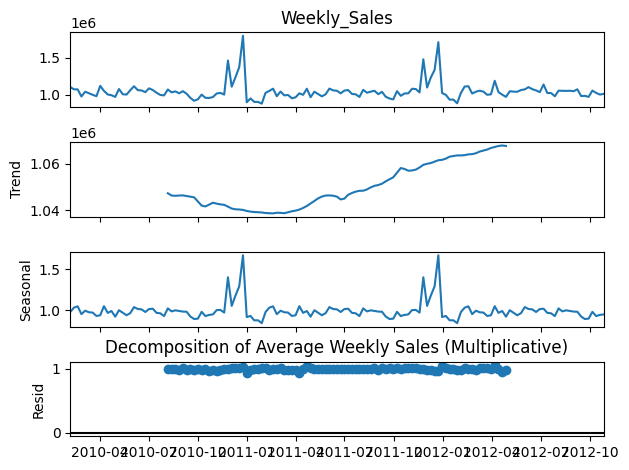

In [ ]:

result.plot()
plt.title('Decomposition of Average Weekly Sales (Multiplicative)')
plt.show()


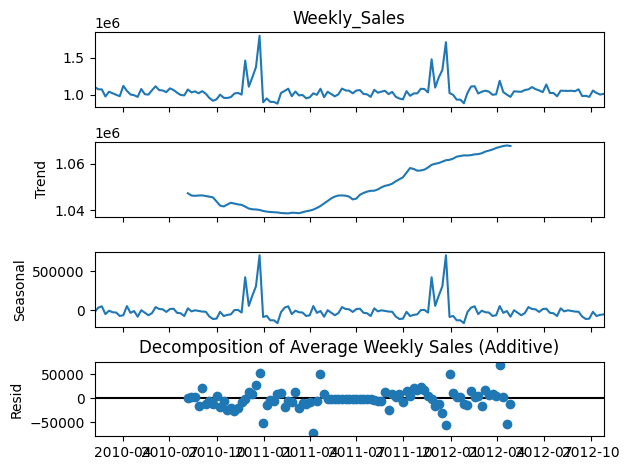

In [ ]:
df = df.sort_index()
decomposition_add = seasonal_decompose(avg_sales, model='additive', period=52)

decomposition_add.plot()
plt.title('Decomposition of Average Weekly Sales (Additive)')
plt.show()

# How to look for best **model**
Additive fits better if the magnitude of seasonal peaks/troughs stays constant through the years.
Example: Your holiday spike is always ~200k higher, no matter if the baseline sales are 1M or 1.5M.

Multiplicative fits better if seasonal variation grows/shrinks in proportion to the trend.

# Additive is best for this case
My time series decomposition shows that the seasonal pattern in weekly sales remains fairly constant in size over the years, while the overall trend is gradually increasing. Comparing the additive and multiplicative models, the additive model fits better because its residuals are centered around zero and display no clear patterns, indicating that trend and seasonality have been effectively captured. Since the seasonal fluctuations do not grow in proportion to the sales level, the additive model is more appropriate for this dataset.


# Average smoothing
Why It’s Useful for  Plot

In  Walmart 2010 example:

Raw data (light blue line) → shows every weekly fluctuation.

Smoothed data (red line) → removes random ups/downs, showing the seasonal trend.

This makes it easier to:

Spot overall trends (upward, downward, or flat).

Identify seasonality (peaks at holidays, dips after them).

Compare trends between different years or stores.
##Window size matters:

Small window → keeps detail, less smooth.

Large window → very smooth, but may hide short-term patterns.

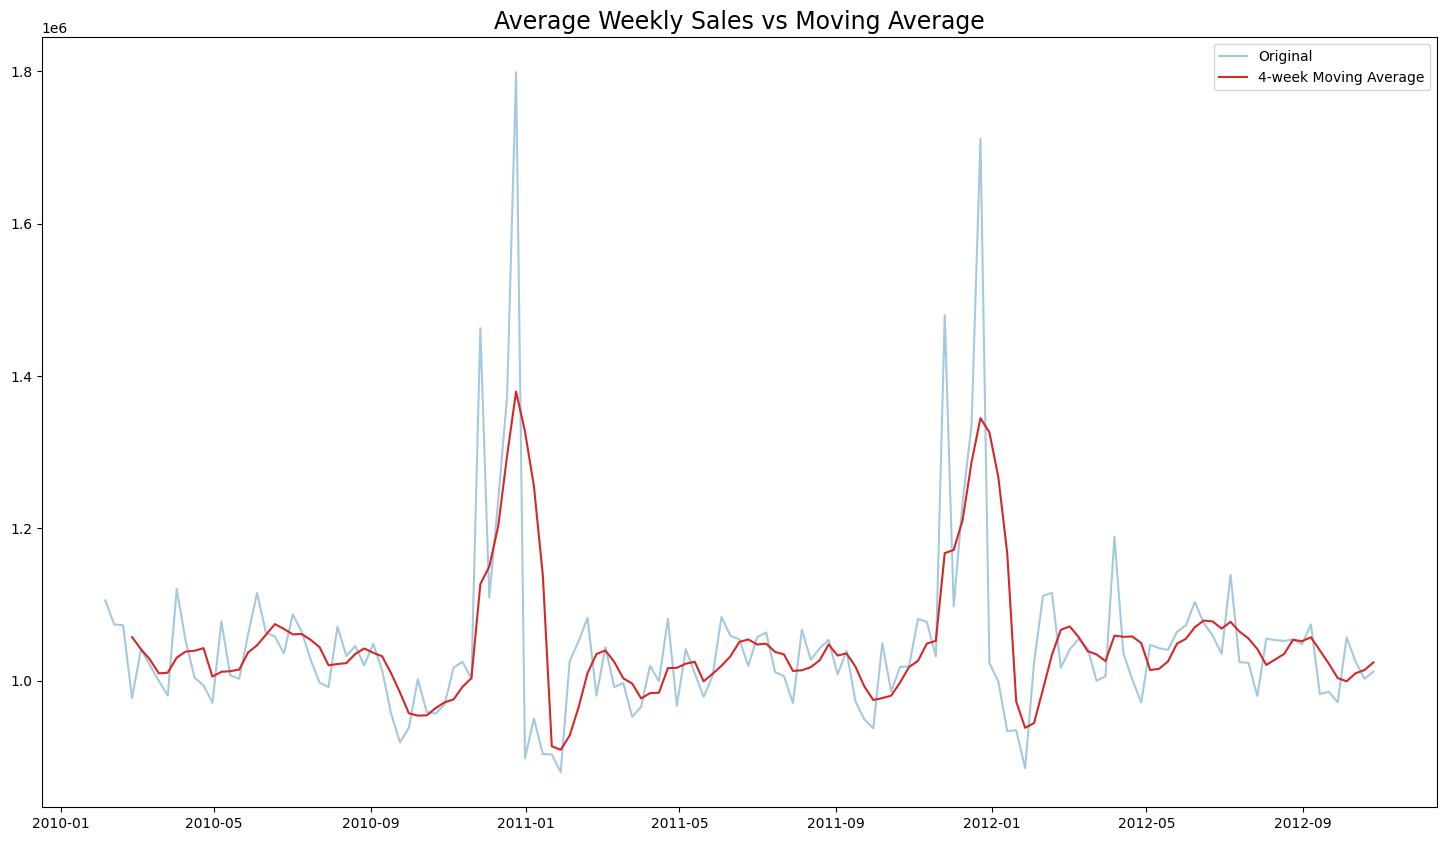

In [ ]:
moving_avg = avg_sales.rolling(window=4).mean()

plt.figure(figsize=(18,10))
plt.plot(avg_sales.index, avg_sales, color='tab:blue', alpha=0.4, label='Original')
plt.plot(moving_avg.index, moving_avg, color='tab:red', label='4-week Moving Average')
plt.title("Average Weekly Sales vs Moving Average", fontsize=17)
plt.legend()
plt.show()


What is a "Window" in Smoothing?

A window is the number of data points you use at a time to calculate each smoothed value.
It slides across your time series like a moving frame.

Think of it like looking at your sales through a magnifying glass that only sees a fixed number of weeks at once.

# Plotting the residuals

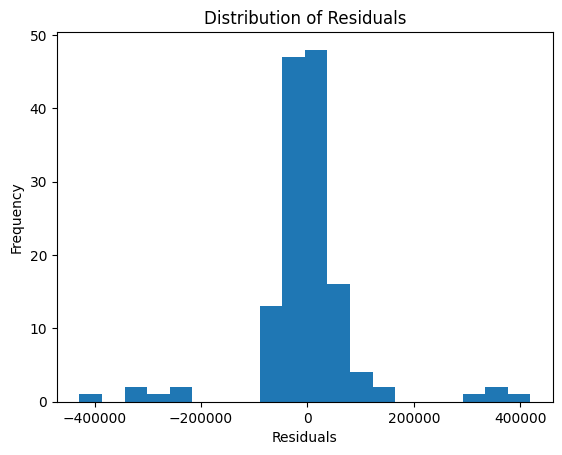

In [ ]:
residual=avg_sales-moving_avg
plt.hist(residual, bins=20)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

The histogram shows the distribution of residuals, i.e., the differences between actual sales (avg_sales) and the moving average (moving_avg).

Each bar represents how many times residuals fall within a certain range.

# Look at the center

“Most residuals are clustered around zero, which means the moving average predictions are generally close to the actual values.”

# Identify residuals greater than 90th percentile and review

In [ ]:
percentile_90 = np.nanpercentile(abs(residual), 90)
outliers = residual[abs(residual) >= percentile_90]

print("Weeks with extreme deviations from trend:")
print(outliers)


Weeks with extreme deviations from trend:
Date
2010-04-02     90128.675444
2010-11-26    335725.793444
2010-12-24    418875.826000
2010-12-31   -428452.382444
2011-01-07   -304763.173000
2011-01-14   -233992.712500
2011-02-04     97395.301667
2011-11-25    312289.256500
2011-12-23    366429.576667
2011-12-30   -302876.121278
2012-01-06   -268111.846889
2012-01-13   -232927.160333
2012-02-10    122370.246889
2012-04-06    129659.923333
Name: Weekly_Sales, dtype: float64



2010-12-24 418875.83 → Sales were about 419k higher than the moving average that week, likely due to Christmas shopping.

2010-12-31 -428452.38 → Sales dropped about 428k below the trend, likely a post-holiday dip.

2011-11-25 312289.26 → Black Friday spike in sales.

Smaller positive or negative numbers (like 2010-04-02 90128.68) indicate less extreme deviations but still above the 90th percentile threshold.

In short:
These are weeks with unusual sales patterns, either spikes or drops, compared to the typical trend captured by the moving average.


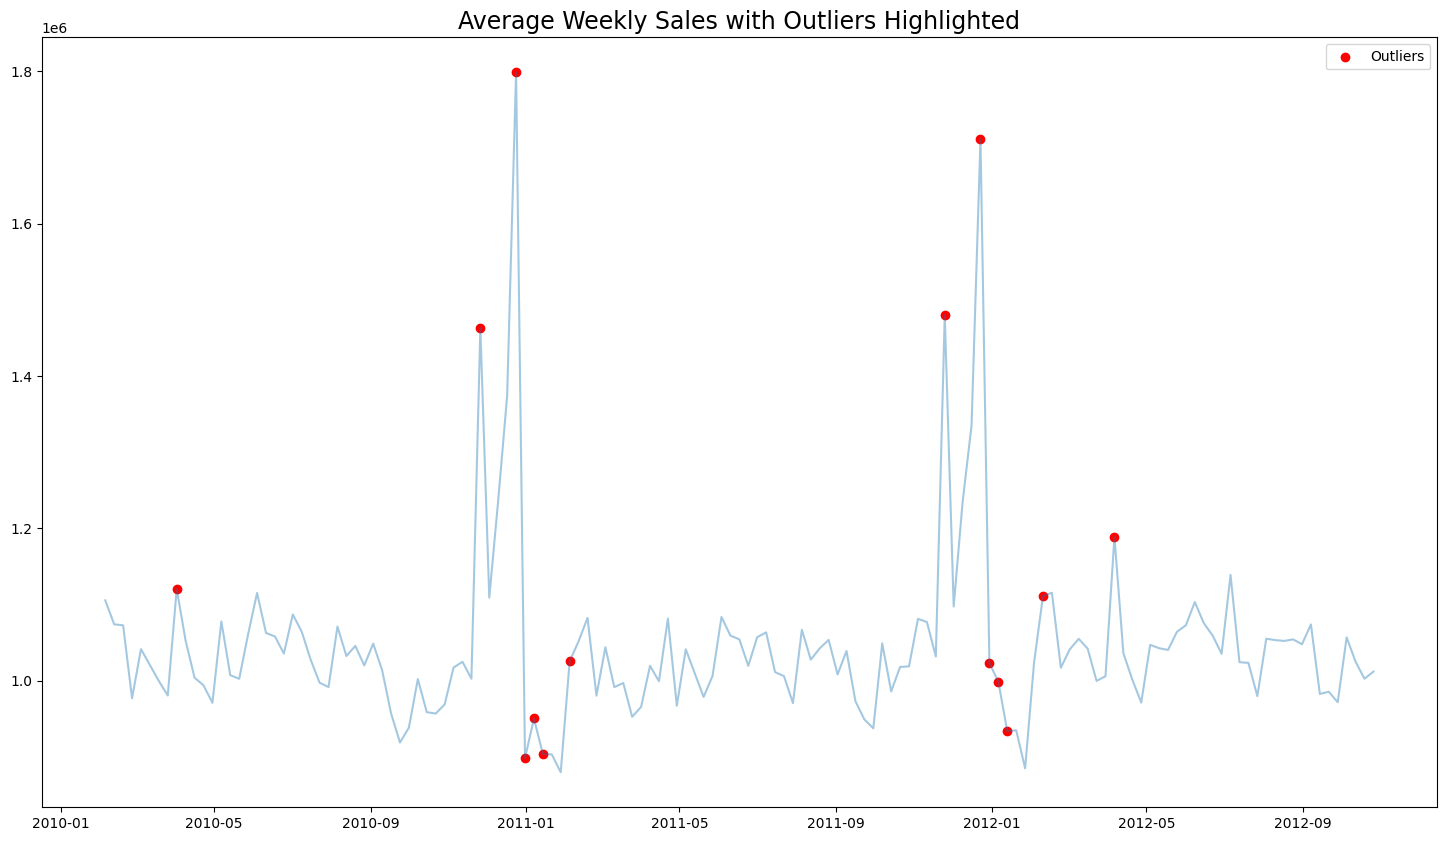

In [ ]:
plt.figure(figsize=(18,10))
plt.plot(avg_sales.index, avg_sales, color='tab:blue', alpha=0.4)
plt.scatter(outliers.index, avg_sales.loc[outliers.index],
            color='red', label='Outliers')
plt.title("Average Weekly Sales with Outliers Highlighted", fontsize=17)
plt.legend()
plt.show()


Outlier weeks (90th percentile)

I calculated the 90th percentile to identify extreme deviations.

“Weeks with residuals above the 90th percentile are considered outliers — sales were significantly different from the trend.”

# Exponential Smoothing
# Concept:

Exponential Smoothing is a time series forecasting method used to smooth out random fluctuations in data and highlight patterns such as trends and seasonality.

In [ ]:
from statsmodels.tsa.api import ExponentialSmoothing
exp=ExponentialSmoothing(avg_sales, trend='add', seasonal='add', seasonal_periods=52).fit().fittedvalues

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)


In [39]:
sub=avg_sales[avg_sales.index.year >= 2012]
fitted_values_subset=exp[exp.index.year >= 2012]

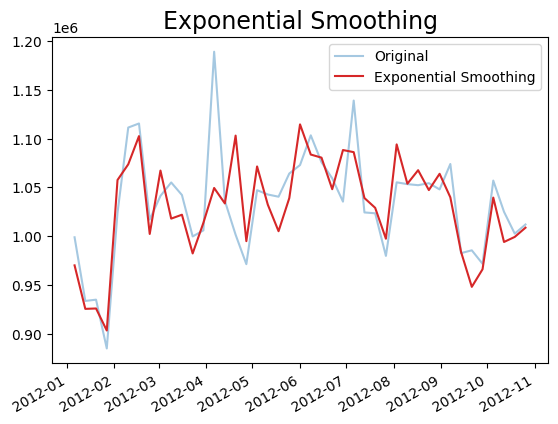

In [42]:
plt.plot(sub.index, sub.values, color='tab:blue', alpha=0.4, label='Original')
plt.plot(fitted_values_subset.index, fitted_values_subset.values, color='tab:red', label='Exponential Smoothing')
plt.gcf().autofmt_xdate()
plt.title("Exponential Smoothing", fontsize=17)
plt.legend()
plt.show()

The plot compares actual weekly sales (blue line) with smoothed sales predicted by Exponential Smoothing (red line) for 2012 and later.”

“The red line represents the underlying trend and seasonal patterns, while the blue line shows the actual observed sales, which may include random fluctuations or unusual spikes.”
Compare actual vs smoothed

“Most of the blue line follows the red line closely, meaning the model captures the overall pattern well.”

“Weeks where the blue line deviates sharply from the red line are outliers, caused by special events, promotions, or unusual sales.”
# Highlight fluctuations

“The difference between the blue and red lines represents residuals or noise.”

“Positive deviations → higher-than-expected sales. Negative deviations → lower-than-expected sales.”

# RESIDUALS

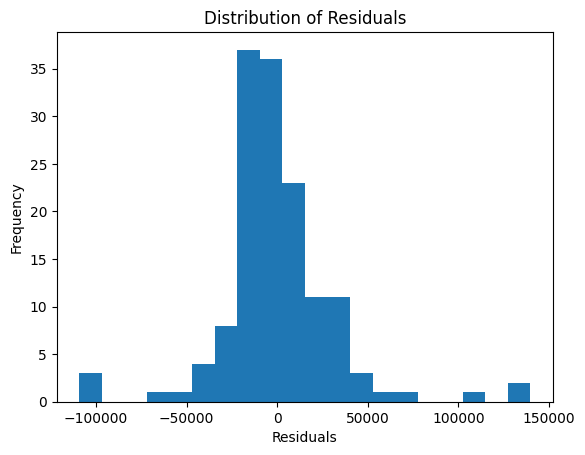

In [43]:
residuals=avg_sales.squeeze()-exp
plt.hist(residuals, bins=20)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Identify residuals greater than 90th percentile and review
The residual histogram shows most weeks have small deviations, meaning the model fits well.

Weeks above the 90th percentile are extreme deviations, which can be investigated for events like holidays, promotions, or anomalies.

This analysis helps in detecting unusual sales patterns beyond the general trend and seasonal effects.

In [44]:
perc=np.nanpercentile(abs(residuals), 90)
outliers=residuals[abs(residuals) >= perc]

print("Weeks with extreme deviations from trend:")
print(outliers)

Weeks with extreme deviations from trend:
Date
2010-02-05     66549.546996
2010-04-02    139698.411475
2010-04-23   -109215.280398
2010-05-28     42848.954219
2011-09-02    -41534.447910
2011-10-21     49961.132252
2011-11-04     47048.231699
2011-12-16    -60035.053128
2011-12-23   -105472.289965
2011-12-30    112542.354437
2012-04-06    139461.055177
2012-04-20   -101452.196248
2012-06-01    -41634.031294
2012-06-29    -52804.205063
2012-07-06     52816.555175
dtype: float64


# Check Stationarity
Concept: Checking Stationarity

Stationarity in a time series means that:

Mean is constant over time (no upward or downward trend).

Variance is constant over time (no increasing or decreasing fluctuations).

Covariance between values depends only on the lag, not the actual time.

Why it matters:

Most time series models (ARIMA, Exponential Smoothing, etc.) assume stationarity.

If a series is non-stationary, forecasts may be unreliable.

Methods to check stationarity:

Visual inspection: Look at plots; check if the series has trends or changing variance.

Rolling statistics: Compute rolling mean and standard deviation to see if they are roughly constant.

Statistical test – Augmented Dickey-Fuller (ADF) test:

Null hypothesis
𝐻
0
H
0
	​

: The series is non-stationary.

Alternative hypothesis
𝐻
1
H
1
	​

: The series is stationary.

If the ADF statistic < critical value or p-value < 0.05, reject
𝐻
0
H
0
	​

 → series is stationary.

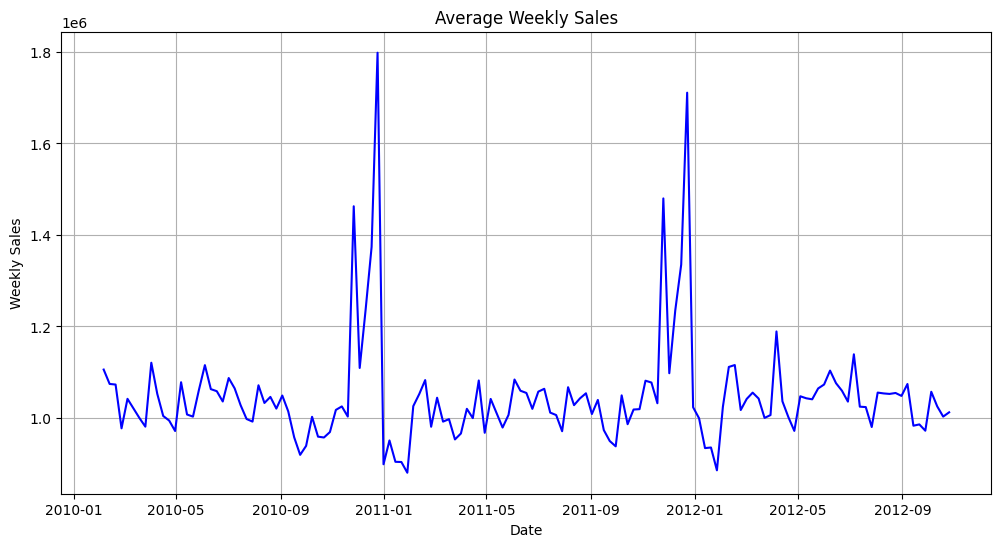

ADF Test Statistic: -5.908298
p-value: 0.000000
Critical Values:
{'1%': np.float64(-3.47864788917503), '5%': np.float64(-2.882721765644168), '10%': np.float64(-2.578065326612056)}
Reject Null Hypothesis - Time Series is Stationary


In [49]:
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# Plot original series
plt.figure(figsize=(12,6))
plt.plot(avg_sales, color='blue')
plt.title("Average Weekly Sales")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.grid(True)
plt.show()

# ADF test
adf_result = adfuller(avg_sales)
print('ADF Test Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])
print('Critical Values:')
print(adf_result[4])

if adf_result[0] < adf_result[4]["5%"]:
    print("Reject Null Hypothesis - Time Series is Stationary")
else:
    print("Failed to Reject Null Hypothesis - Time Series is Non-Stationary")


# Differencing Time series data

In [50]:
from google.colab import files

# Open file picker
uploaded = files.upload()

Saving Balaji Fast Food Sales.csv to Balaji Fast Food Sales.csv


In [52]:
sales_data=pd.read_csv('Balaji Fast Food Sales.csv')

In [53]:
sales_data.head()

,order_id,date,item_name,item_type,item_price,quantity,transaction_amount,transaction_type,received_by,time_of_sale
0,1,07-03-2022,Aalopuri,Fastfood,20,13,260,NaN,Mr.,Night
1,2,8/23/2022,Vadapav,Fastfood,20,15,300,Cash,Mr.,Afternoon
2,3,11/20/2022,Vadapav,Fastfood,20,1,20,Cash,Mr.,Afternoon
3,4,02-03-2023,Sugarcane juice,Beverages,25,6,150,Online,Mr.,Night
4,5,10-02-2022,Sugarcane juice,Beverages,25,8,200,Online,Mr.,Evening


In [55]:
# Keep only 'date' and 'transaction_amount' columns
sales_data = sales_data[['date', 'transaction_amount']]


In [56]:
sales_data.head()

,date,transaction_amount
0,07-03-2022,260
1,8/23/2022,300
2,11/20/2022,20
3,02-03-2023,150
4,10-02-2022,200


In [65]:
sales_data['date'] = pd.to_datetime(sales_data['date'], dayfirst=False, errors='coerce')

/tmp/ipython-input-3472196463.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_data['date'] = pd.to_datetime(sales_data['date'], dayfirst=False, errors='coerce')


In [66]:
sales_data.set_index('date', inplace=True)

In [78]:
sales_data.head()
# 5. Aggregate sales per day (if multiple transactions per day)
sales_data = sales_data.groupby('date').sum()

# 6. Sort by date (index is now 'date')
sales_data = sales_data.sort_index()

In [79]:
sales_data['Difference']=sales_data['transaction_amount'].diff()

In [80]:
sales_data=sales_data.dropna()

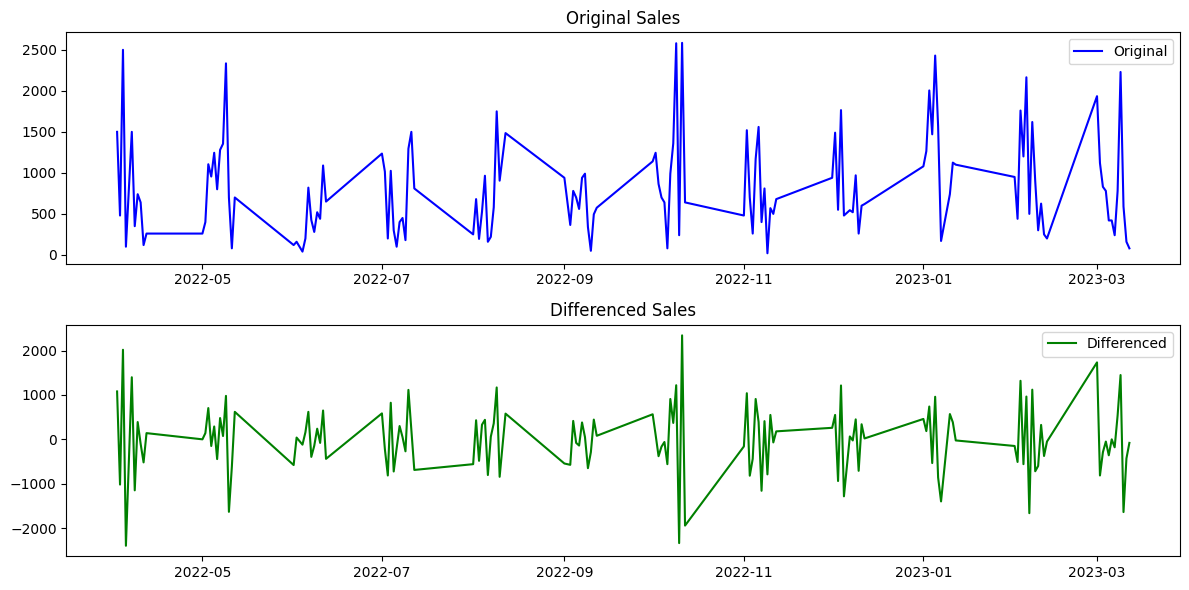

In [81]:
plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
plt.plot(sales_data['transaction_amount'], color='blue', label='Original')
plt.title('Original Sales')
plt.legend()

plt.subplot(2,1,2)
plt.plot(sales_data['Difference'], color='green', label='Differenced')
plt.title('Differenced Sales')
plt.legend()

plt.tight_layout()
plt.show()


In [84]:
from statsmodels.tsa.stattools import adfuller

# Drop the first NaN after differencing
diff_series = sales_data['Difference'].dropna()

# ADF test
adf_result = adfuller(diff_series)

print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])

if adf_result[1] < 0.05:
    print("Time Series is Stationary")
else:
    print("Time Series is Non-Stationary")


ADF Statistic: -6.169788886957284
p-value: 6.84946158208695e-08
Time Series is Stationary


From the graph, we can observe that the original sales series was **non-stationary**, showing trends and fluctuations over time. After applying first-order differencing, the series becomes **stationary**, with a roughly constant mean and variance, making it suitable for time series modeling.


# Autocorrelation
What is Autocorrelation?

Autocorrelation measures the correlation of a time series with a lagged version of itself. In simple words, it tells you how past values influence current values.

If a time series has high autocorrelation at lag 1, it means the value this week is strongly related to the value last week.

If autocorrelation is low, past values have little influence on the current value.

In [106]:
avg_sales.head()

,Weekly_Sales
Date,
2010-02-05,1.105572e+06
2010-02-12,1.074148e+06
2010-02-19,1.072822e+06
2010-02-26,9.770794e+05
2010-03-05,1.041588e+06


In [107]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

Autocorrelation values:
Lag 0 : 1.0
Lag 1 : 0.34
Lag 2 : 0.22
Lag 3 : 0.07
Lag 4 : 0.17
Lag 5 : -0.23
Lag 6 : -0.16
Lag 7 : -0.08
Lag 8 : -0.08
Lag 9 : -0.13
Lag 10 : -0.11
Lag 11 : -0.06
Lag 12 : -0.11
Lag 13 : -0.11
Lag 14 : -0.09
Lag 15 : 0.01
Lag 16 : 0.0
Lag 17 : 0.0
Lag 18 : -0.04
Lag 19 : -0.01
Lag 20 : -0.03
Lag 21 : -0.06
Lag 22 : -0.05
Lag 23 : 0.02
Lag 24 : 0.07


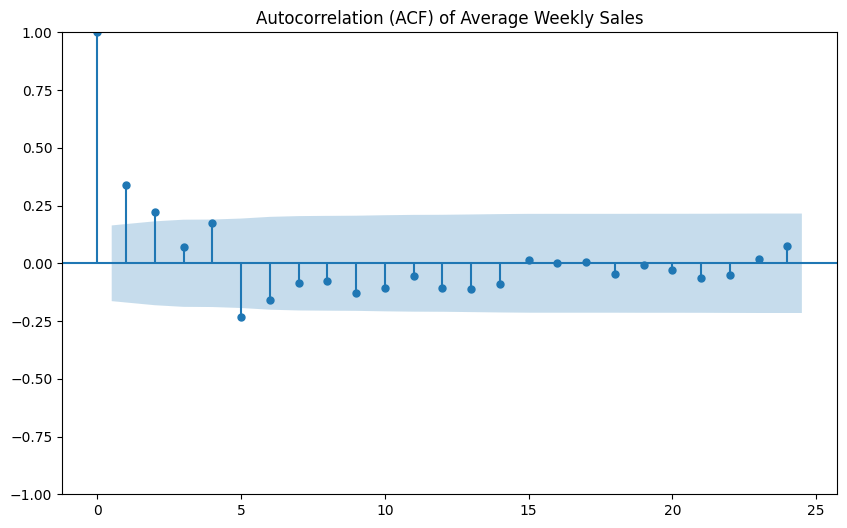

In [108]:
acf_values = acf(avg_sales, nlags=24)

print("Autocorrelation values:")
for i in range(25):
    print("Lag", i, ":", np.round(acf_values[i], 2))

# Plot ACF
fig = plot_acf(avg_sales, lags=24)
fig.set_size_inches((10, 6))
plt.title("Autocorrelation (ACF) of Average Weekly Sales")
plt.show()


Understanding the Output

Lag 0 = 1.0

This is always 1 because a series is perfectly correlated with itself.

Lag 1 = 0.34

Weekly sales this week have a moderate positive correlation with last week’s sales.

If last week’s sales were high, this week is likely to be somewhat high too.

Lag 2 = 0.22

Sales two weeks ago still have a small positive correlation with current sales, but weaker than lag 1.

Lag 3 = 0.07

Almost no correlation; past 3 weeks don’t strongly affect current sales.

Lag 4 = 0.17

Slight positive correlation again; could indicate some weekly or monthly patterns.

Negative correlations (e.g., Lag 5 = -0.23, Lag 6 = -0.16)

Sales from 5–6 weeks ago are slightly inversely related to current sales.

For example, a high sales week 5 weeks ago might slightly correspond to a lower sales week now.

Values close to 0 (Lag 15–Lag 20)

These weeks in the past have almost no linear correlation with current sales.

Pattern summary

Rapidly decreasing correlation after lag 1–2 → indicates that sales are mostly influenced by the recent 1–2 weeks.

Some minor fluctuations for lags 4–6 suggest possible weak short-term cycles.

Overall, there is no strong long-term trend in autocorrelation, meaning past weeks beyond 2–3 weeks don’t strongly predict current sales.

# Partial Autocorrelation (PACF)
What is PACF?

PACF measures the correlation between a time series and its lagged values after removing the influence of all shorter lags.

In simple words:

ACF tells you total correlation at each lag.

PACF tells you the direct correlation at each lag, ignoring correlations from intermediate lags.

Why PACF is Useful

Isolate the effect of each lag

Example: Sales today might correlate with last week (lag 1) and the week before (lag 2).

PACF at lag 2 removes the effect of lag 1 to show the true influence of 2 weeks ago.

Helps in ARIMA modeling

For an AR(p) model, the number of significant lags in PACF tells you the AR order (p).


Partial Autocorrelation values:
Lag 0 : 1.0
Lag 1 : 0.34
Lag 2 : 0.12
Lag 3 : -0.04
Lag 4 : 0.16
Lag 5 : -0.39
Lag 6 : -0.02
Lag 7 : 0.1
Lag 8 : -0.12
Lag 9 : 0.06
Lag 10 : -0.14
Lag 11 : -0.07
Lag 12 : -0.02
Lag 13 : -0.11
Lag 14 : 0.0
Lag 15 : 0.06
Lag 16 : -0.03
Lag 17 : -0.02
Lag 18 : -0.13
Lag 19 : -0.05
Lag 20 : 0.02
Lag 21 : -0.09
Lag 22 : 0.01
Lag 23 : 0.01
Lag 24 : 0.03


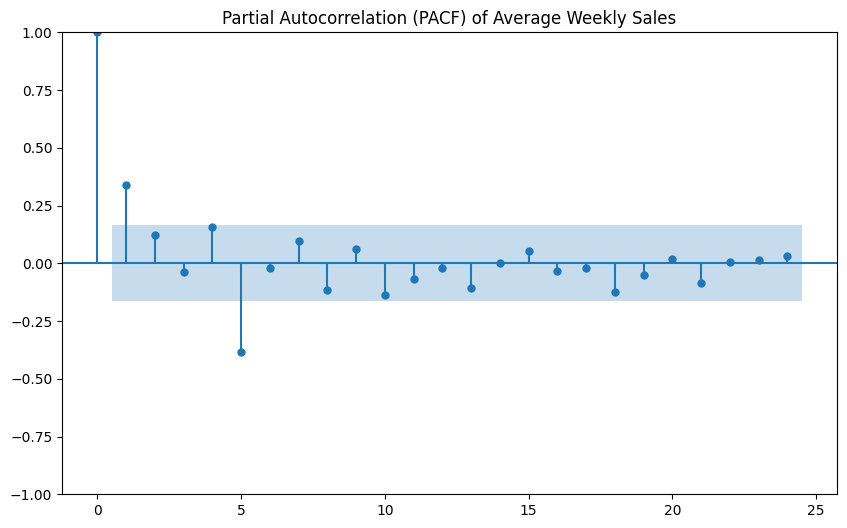

In [109]:
pacf_values = pacf(avg_sales, nlags=24, method='ols')

print("\nPartial Autocorrelation values:")
for i in range(25):
    print("Lag", i, ":", np.round(pacf_values[i], 2))

# Plot PACF
fig = plot_pacf(avg_sales, lags=24, method='ols')
fig.set_size_inches((10, 6))
plt.title("Partial Autocorrelation (PACF) of Average Weekly Sales")
plt.show()

Current week’s sales are mostly influenced by last week’s sales (lag 1).

Weak influence from weeks 2–5.

Beyond 5 weeks, previous sales do not directly affect current sales.